# Injected signal onto Gaussian noise with ```bilby```
Throuth the notebook we use the ```igwn-py310``` conda environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcparams = {
          'axes.labelsize': 10,
          'font.size': 10,
          'text.latex.preamble': (            # LaTeX preamble
          r'\usepackage{revtex4-2}'),
          'legend.fontsize': 10,
          'xtick.color': 'k',
          'xtick.labelsize': 10,
          'ytick.color': 'k',
          'ytick.labelsize': 10,
          'text.usetex': False,
          'font.family': 'STIXGeneral',
          'mathtext.fontset': 'stix',
          'text.color': 'k',
          'figure.figsize': (8.08, 5.),     
          'figure.dpi': 150,
          'figure.autolayout': True
          }
rcparams['axes.linewidth'] = 0.5

color = {'L1': {'asd':'#455A64','signal':'#f2ab15','noise':'lightgray'},
          'H1': {'asd':'#455A64','signal':'#0f9b8e','noise':'lightgray'},
          'V1': {'asd':'#455A64','signal': '#ca0147','noise':'lightgray'}
         }
import bilby

We can generate Gaussian noise and then make the injection. But in future examples, this step is not required because we will use real data.

In [2]:
# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.0
sampling_frequency = 2048.0
minimum_frequency = 20
# Set up a random seed for result reproducibility.  This is optional!
bilby.core.utils.random.seed(88170235)

In [3]:
import logging
import io
bilby_logger = logging.getLogger('bilby')
bilby_logger.propagate = False
handler = logging.StreamHandler(stream=io.StringIO())
bilby_logger.addHandler(handler)
bilby_logger.setLevel(logging.WARNING)


In [4]:
# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency, )

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

# Set up interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])

Another way to set up the interferometers:
```python
import gwinc

# create a new detector using a PyGwinc sensitivity curve
curve = gwinc.load_budget("Aplus").run()

# Set up two other detectors at Hanford and Livingston
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1"])
for ifo in interferometers:
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=curve.freq, psd_array=curve.psd
    )
```

In [5]:
injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=2000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=0.2108,
)
start_time=injection_parameters["geocent_time"] - 2 + duration
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=start_time,
)
hphc = ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)

21:38 bilby WARNING : Injecting signal outside segment, start_time=1126259644.413, merger time=1126259642.413.
21:38 bilby WARNING : Injecting signal outside segment, start_time=1126259644.413, merger time=1126259642.413.


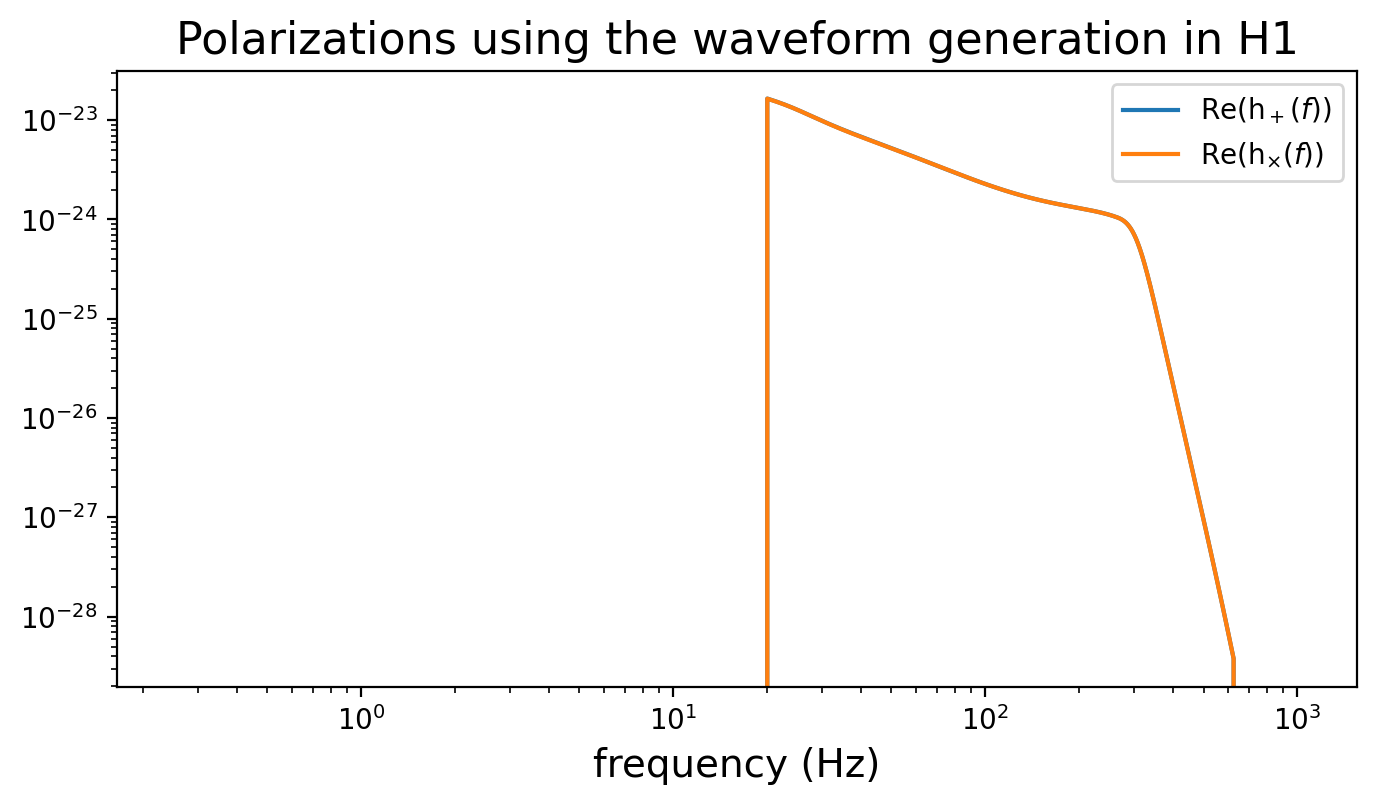

In [6]:
plt.figure(figsize=(8,4))
plt.loglog(ifos.frequency_array, abs(hphc[0]['plus']), label=r'Re(h$_+(f)$)')
plt.loglog(ifos.frequency_array, abs(hphc[0]['cross']), label=r'Re(h$_{\times}(f)$)')
plt.legend(loc='best')
plt.xlabel('frequency (Hz)', fontsize=14)
plt.title("Polarizations using the waveform generation in {}".format(str(ifos[0].name)), fontsize=16);

Text(0.5, 1.0, 'Detector response to incident GW in H1 and L1')

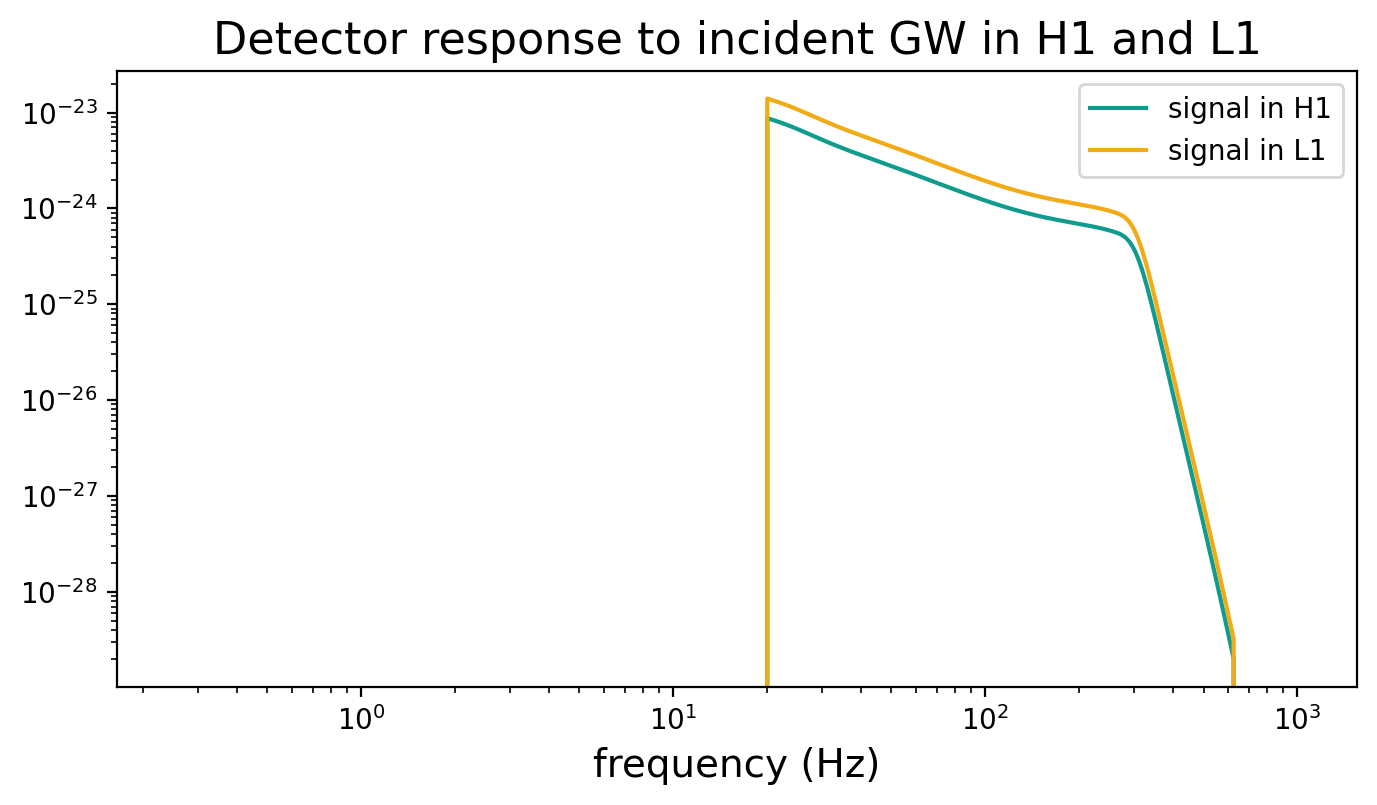

In [7]:
freqs = ifos.frequency_array
plt.figure(figsize=(8,4))
for ifo in range(ifos.number_of_interferometers):
    name = ifos[ifo].name
    signal = ifos[ifo].get_detector_response(
        waveform_generator.frequency_domain_strain(), injection_parameters)
    plt.loglog(freqs, abs(signal), color=color[str(name)]['signal'], label=r'signal in {}'.format(str(name)))
plt.xlabel('frequency (Hz)', fontsize=14)
#plt.ylabel('strain', fontsize=14)
plt.legend(loc='best')
#plt.xlim(-2,1)
plt.title("Detector response to incident GW in H1 and L1", fontsize=16)

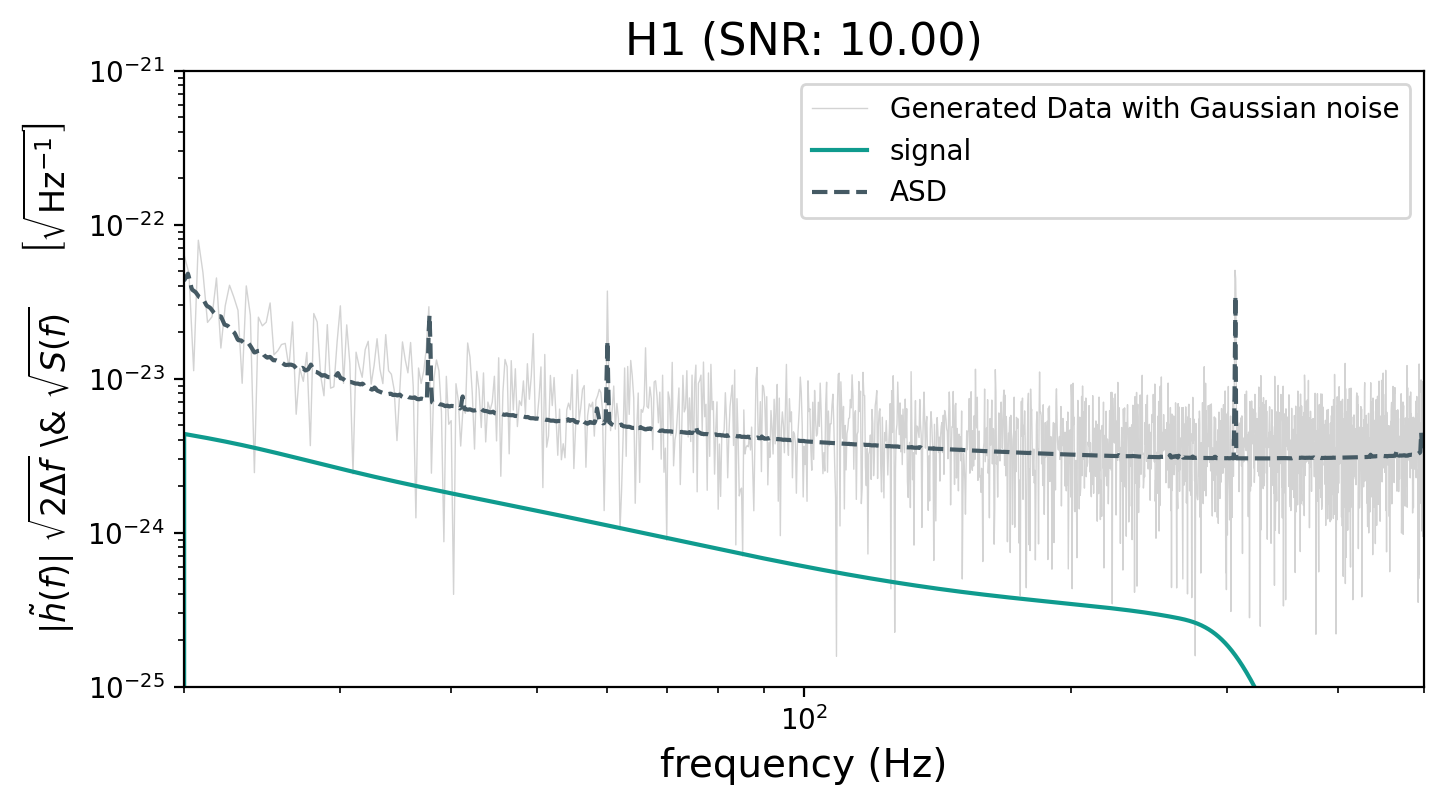

In [8]:
plt.figure(figsize=(8,4))
ifo = 0
df = freqs[1]-freqs[0]
name = ifos[ifo].name
signal = ifos[ifo].get_detector_response(
        waveform_generator.frequency_domain_strain(), injection_parameters)
strain = abs(ifos[ifo].strain_data.frequency_domain_strain)
plt.loglog(freqs, strain, label=r'Generated Data with Gaussian noise', color=color[str(name)]['noise'], lw=0.5)
plt.loglog(freqs, np.sqrt(df)*abs(signal), label=r'signal', color=color[str(name)]['signal'])
plt.loglog(ifos[ifo].power_spectral_density.frequency_array, np.sqrt(ifos[ifo].power_spectral_density.psd_array), 
                color=color[str(name)]['asd'], linestyle='dashed', label='ASD')
plt.xlabel('frequency (Hz)', fontsize=14)
plt.ylabel(r'$|\tilde{h}(f)|~\sqrt{2\Delta f}$ \& $\sqrt{S(f)}$ $\quad$ $\left[\sqrt{\rm{Hz^{-1}}}\right]$', fontsize=12)
plt.legend(loc='best')
plt.xlim(20,500);
plt.ylim(1e-25,1e-21);
plt.title("{} (SNR: {:.2f})".format(str(name),np.sqrt(ifos[ifo].optimal_snr_squared(signal=signal).real)), fontsize=16);

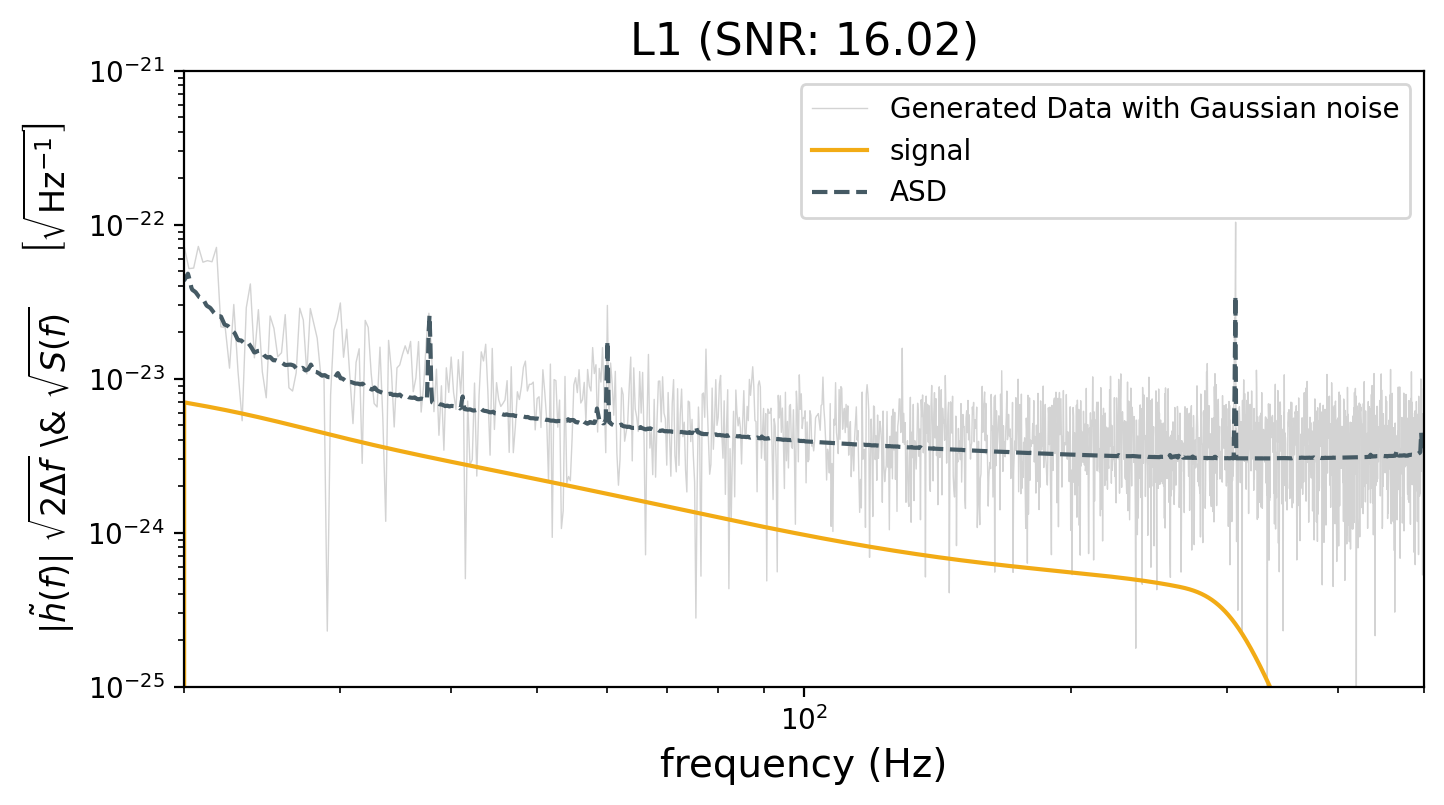

In [9]:
plt.figure(figsize=(8,4))
ifo = 1
df = freqs[1]-freqs[0]
name = ifos[ifo].name
signal = ifos[ifo].get_detector_response(
        waveform_generator.frequency_domain_strain(), injection_parameters)
strain = abs(ifos[ifo].strain_data.frequency_domain_strain)
plt.loglog(freqs, strain, label=r'Generated Data with Gaussian noise', color=color[str(name)]['noise'], lw=0.5)
plt.loglog(freqs, np.sqrt(df)*abs(signal), label=r'signal', color=color[str(name)]['signal'])
plt.loglog(ifos[ifo].power_spectral_density.frequency_array, np.sqrt(ifos[ifo].power_spectral_density.psd_array), 
                color=color[str(name)]['asd'], linestyle='dashed', label='ASD')
plt.xlabel('frequency (Hz)', fontsize=14)
plt.ylabel(r'$|\tilde{h}(f)|~\sqrt{2\Delta f}$ \& $\sqrt{S(f)}$ $\quad$ $\left[\sqrt{\rm{Hz^{-1}}}\right]$', fontsize=12)
plt.legend(loc='best')
plt.xlim(20,500);
plt.ylim(1e-25,1e-21);
plt.title("{} (SNR: {:.2f})".format(str(name),np.sqrt(ifos[ifo].optimal_snr_squared(signal=signal).real)), fontsize=16);

Let's visualize the signal and the response in the time-domain!

In [10]:
from bilby.gw.detector import strain_data
strain_class = strain_data.InterferometerStrainData()
strain_class.set_from_frequency_domain_strain(frequency_domain_strain=signal, sampling_frequency=sampling_frequency, 
duration=duration, start_time=start_time)

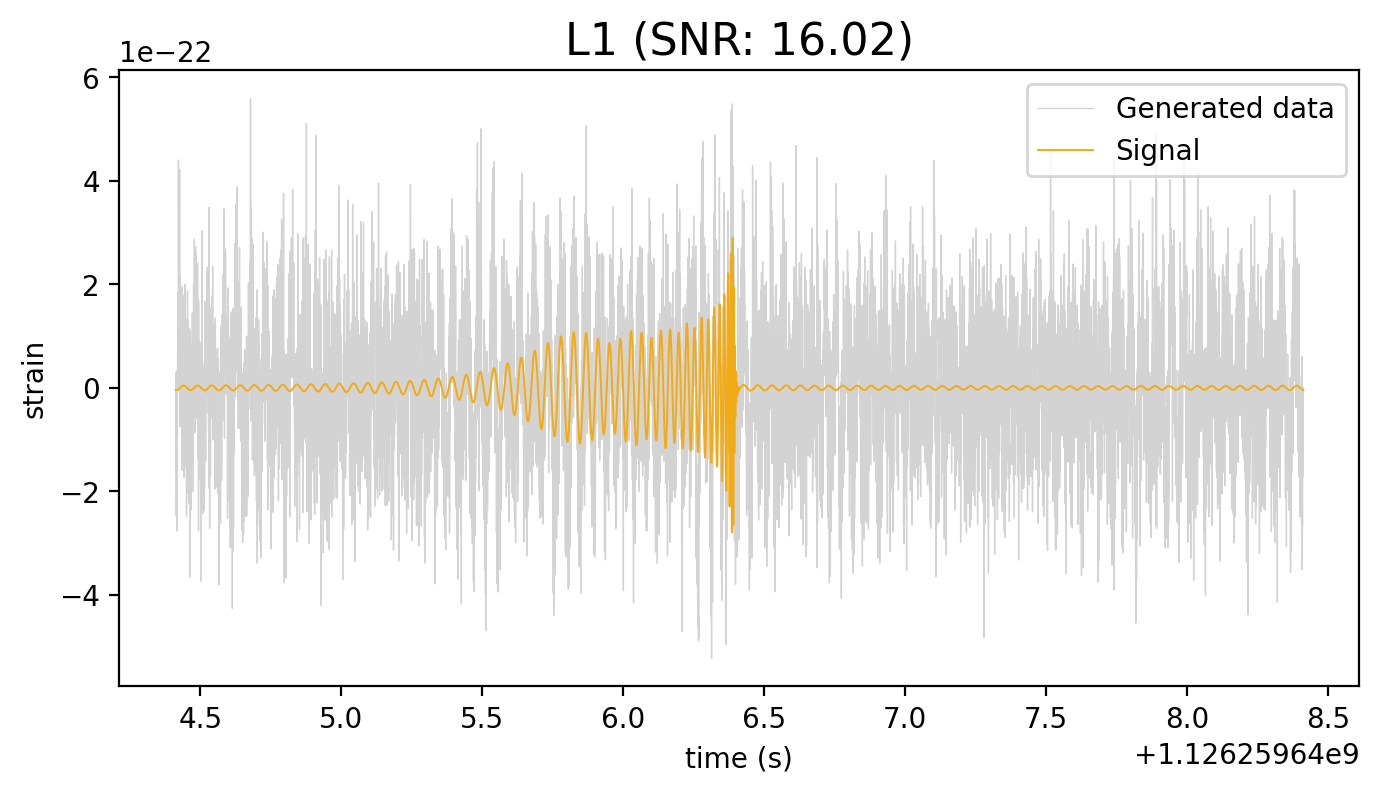

In [11]:
plt.figure(figsize=(8,4))
ifo = 1
df = freqs[1]-freqs[0]
name = ifos[ifo].name
times = ifos[ifo].strain_data.time_array
dt = ifos[ifo].strain_data.time_array[1]-ifos[ifo].strain_data.time_array[0]
strain_td = ifos[ifo].strain_data.time_domain_strain
signal_td = strain_class.time_domain_strain
plt.plot(times, strain_td, color=color[str(name)]['noise'], label='Generated data', lw=0.5)
plt.plot(times, signal_td, color=color[str(name)]['signal'], label='Signal', lw=0.7)
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.legend(loc=0);
plt.title("{} (SNR: {:.2f})".format(str(name),np.sqrt(ifos[ifo].optimal_snr_squared(signal=signal).real)), fontsize=16);

Remember:
$$\delta_t = 1/f_{sampling} $$
$$\delta_f = \frac{\delta_t}{T_{obs}/f_{sampling}}$$
$$N_t = \frac{T_{obs}}{\delta_t}$$
$$f_{Nyquist} = \frac{f_{sampling}}{2}$$
$$N_f = N_t/2 = \frac{f_{Nyquist}}{\delta_f}$$

In [12]:
dt

0.00048828125

In [13]:
1/sampling_frequency

0.00048828125

In [14]:
dt/(duration/sampling_frequency)

0.25

In [15]:
(duration/dt)/2

4096.0

In [16]:
(sampling_frequency/2)/0.25

4096.0

# Q-transforms!

In [17]:
times-1126259642.413

array([2.        , 2.00048828, 2.00097656, ..., 5.99853516, 5.99902344,
       5.99951172])

In [18]:
1126259642.413

1126259642.413

/home/argyro.sasli/.conda/envs/tests/lib/python3.9/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 500.00 is too high for the given Q range, resetting to 471.32
  warnings.warn('upper frequency of %.2f is too high for the given '


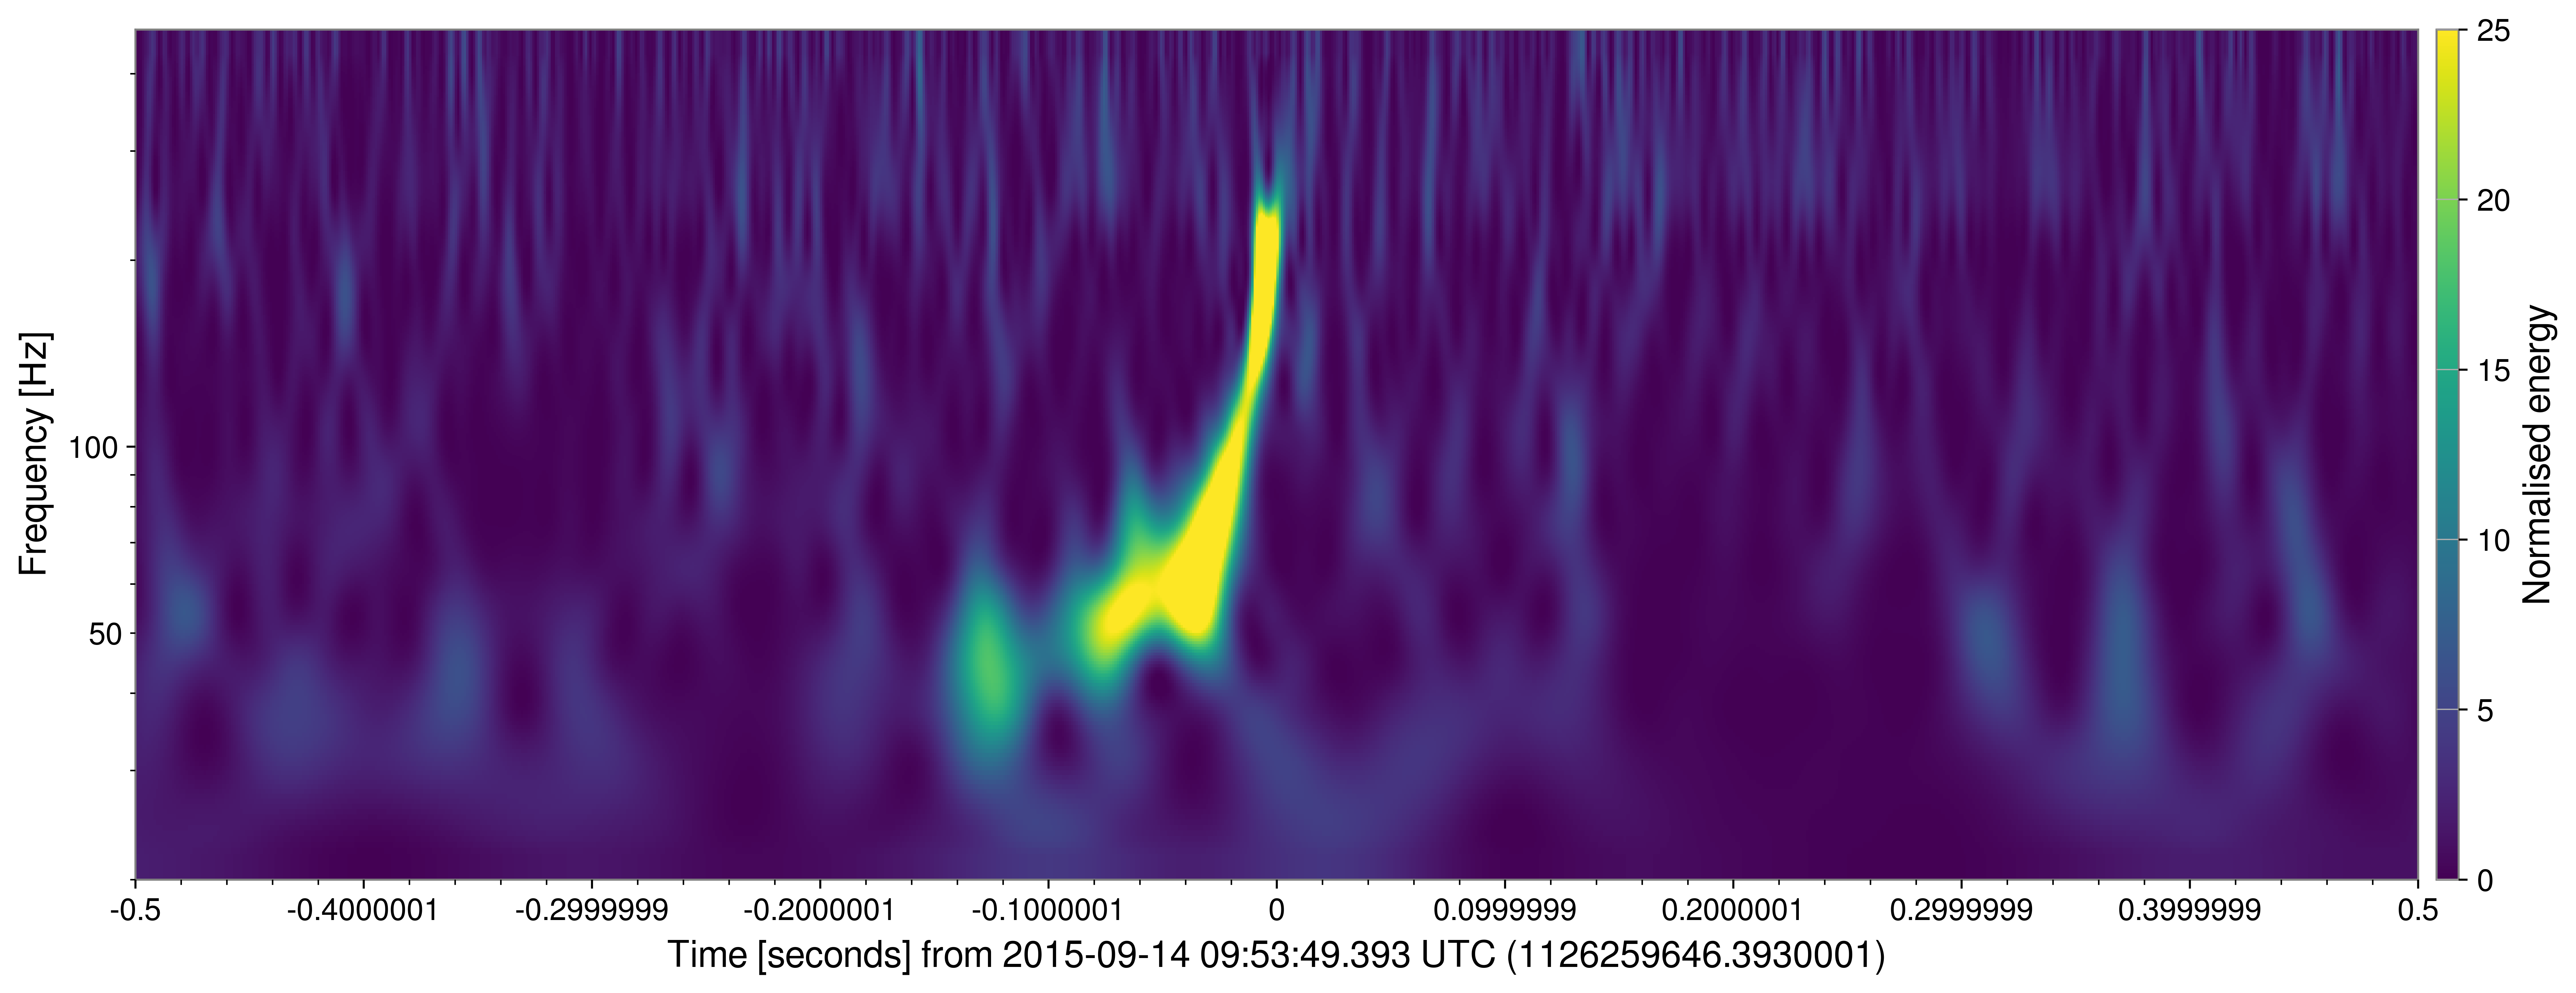

In [19]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
data = TimeSeries(strain_td, t0=times[0], dt=dt)
asd = np.sqrt(ifos[ifo].power_spectral_density.psd_array)
q = data.q_transform(frange=(20, 500), fduration=1, tres=0.001, qrange=(2, 16), whiten=asd)
plot = q.plot(figsize=(16, 6), dpi=300)
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy", vmin = 0, vmax =25)
ax.grid(False)
ax.set_epoch(1126259642.413+4-0.02)
ax.set_xlim(1126259642.413+4-0.02 - 0.5 , 1126259642.413+4-0.02 + 0.5 )

#plt.axvline(x=concatenated_df['GWSPY Event Time'][index], color='r', linestyle='--', label='GWSPY Event Time')

plot.show(warn=False)

# $~fin$